## **Exam Scores Prediction**

The dataset contains test scores from three different subjects at a fictional public school. This dataset also contains variables about various personal and socio-economic factors for each student.

The goal is to provide an analysis on how several variables could affect a student's exam score and to predict future exam scores given those variables.

*Credits to the creator of the original dataset, **Mr. Royce Kimmons**, and to the uploaded dataset in **[Kaggle](https://www.kaggle.com/datasets/desalegngeb/students-exam-scores/data)***.

### **Data Description**

Column | Description |
-----|-----|
Gender | Gender of the student (male/female) |
EthnicGroup | Ethnic group of the student (group A to E) |
ParentEduc | Parent(s) education background (from some_highschool to master's degree) |
LunchType | School lunch type (standard or free/reduced) |
TestPrep | Test preparation course followed (completed or none) |
ParentMaritalStatus | Parent(s) marital status (married/single/widowed/divorced) |
PracticeSport | How often the student practice sport (never/sometimes/regularly) |
IsFirstChild | If the first child in the family or not (yes/no) |
NrSiblings | Number of siblings the student has (0 to 7) |
TransportMeans | Means of transport to school (schoolbus/private) |
WklyStudyHours | Weekly self-study hours(less than 5hrs, between 5 and 10 hrs, more than 10 hours) |
MathScore | Math test score (0-100) |
ReadingScore | Reading test score (0-100) |
WritingScore | Writing test score (0-100) |

### **Preparation**

In [2]:
## For data manipulation

import numpy as np
import pandas as pd

## For data visualization

import matplotlib.pyplot as plt
import seaborn as sns

## For displaying all columns in the dataframe

pd.set_option('display.max_columns', None)

## For data modelling

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## For metrics and helpful functions

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
from sklearn.tree import plot_tree

## For saving models

import pickle

## Miscellaneous

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Data Exploration**

In [42]:
## Load the dataset

exam_scores = pd.read_csv("D:\Documents\CSV Datasets\Student Marks\Expanded_data_with_more_features.csv")

exam_scores.head(10)

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
5,5,female,group B,associate's degree,standard,none,married,regularly,yes,1.0,school_bus,5 - 10,73,84,79
6,6,female,group B,some college,standard,completed,widowed,never,no,1.0,private,5 - 10,85,93,89
7,7,male,group B,some college,free/reduced,none,married,sometimes,yes,1.0,private,> 10,41,43,39
8,8,male,group D,high school,free/reduced,completed,single,sometimes,no,3.0,private,> 10,65,64,68
9,9,female,group B,high school,free/reduced,none,married,regularly,yes,NaN,private,< 5,37,59,50


In [43]:
## Inspect basic info about the data

print(exam_scores.shape)

exam_scores.info()

(30641, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           30641 non-null  int64  
 1   Gender               30641 non-null  object 
 2   EthnicGroup          28801 non-null  object 
 3   ParentEduc           28796 non-null  object 
 4   LunchType            30641 non-null  object 
 5   TestPrep             28811 non-null  object 
 6   ParentMaritalStatus  29451 non-null  object 
 7   PracticeSport        30010 non-null  object 
 8   IsFirstChild         29737 non-null  object 
 9   NrSiblings           29069 non-null  float64
 10  TransportMeans       27507 non-null  object 
 11  WklyStudyHours       29686 non-null  object 
 12  MathScore            30641 non-null  int64  
 13  ReadingScore         30641 non-null  int64  
 14  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(4),

The dataset has 30641 rows and 15 columns.

Upon inspection of the dataset info, the following columns were found to have `null` rows:
- EthnicGroup (1840 null values)
- ParentEduc (1845 null values)
- TestPrep (1830 null values)
- ParentMaritalStatus (1190 null values)
- PracticeSport (631 null values)
- IsFirstChild (904 null values)
- NrSiblings (1572 null values)
- TransportMeans (3134 null values)
- WklyStudyHours (955 null values)

These columns should not have null values, so we will drop all null values.

`NrSiblings` columns should only contain whole number, therefore, we will change its data type into `int`.

#### **Removing Null Values and Unnecessary Columns**

The first 'unnamed' column, the 'Gender' column , and the 'EthnicGroup' column will be removed, as it will not have an impact for the analysis and the model. The null values from the dataset will also be removed. The datatype for the `NrSiblings` column should also be changed to `int` as it will only contain discrete variables.

In [47]:
## Drop null values from all columns

exam_scores = exam_scores.dropna(axis=0)

## Drop unnecessary column in the dataset

exam_scores = exam_scores.drop(exam_scores.columns[0], axis=1)

In [49]:
## Change data type of 'NrSiblings' variables into int

exam_scores.NrSiblings = exam_scores.NrSiblings.astype(int)

print(exam_scores.shape)

exam_scores.info()

(19243, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 19243 entries, 2 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               19243 non-null  object
 1   EthnicGroup          19243 non-null  object
 2   ParentEduc           19243 non-null  object
 3   LunchType            19243 non-null  object
 4   TestPrep             19243 non-null  object
 5   ParentMaritalStatus  19243 non-null  object
 6   PracticeSport        19243 non-null  object
 7   IsFirstChild         19243 non-null  object
 8   NrSiblings           19243 non-null  int32 
 9   TransportMeans       19243 non-null  object
 10  WklyStudyHours       19243 non-null  object
 11  MathScore            19243 non-null  int64 
 12  ReadingScore         19243 non-null  int64 
 13  WritingScore         19243 non-null  int64 
dtypes: int32(1), int64(3), object(10)
memory usage: 2.1+ MB


After removing all the null values and unnecessary column in the dataset, the dataset is only left with 19243 rows and 14 columns. The variables of `NrSiblings` column has also been changed into `int` data type.

Next is to rename the columns to make it more legible and to standardize them using snake_case.

In [50]:
## Rename columns in the dataset

exam_scores.rename(columns={'Gender':'gender',
                   'EthnicGroup':'ethnic_group',
                   'ParentEduc':'parents_education',
                   'LunchType':'lunch_type',
                   'TestPrep':'test_preparation',
                   'ParentMaritalStatus':'parent_marital_status',
                   'PracticeSport':'practice_sports',
                   'IsFirstChild':'is_first_child',
                   'NrSiblings':'number_of_siblings',
                   'TransportMeans':'transport_means',
                   'WklyStudyHours':'weekly_study_hours',
                   'MathScore':'math_score',
                   'ReadingScore':'reading_score',
                   'WritingScore':'writing_score'}, inplace=True)

exam_scores.head()

,gender,ethnic_group,parents_education,lunch_type,test_preparation,parent_marital_status,practice_sports,is_first_child,number_of_siblings,transport_means,weekly_study_hours,math_score,reading_score,writing_score
2,female,group B,master's degree,standard,none,single,sometimes,yes,4,school_bus,< 5,87,93,91
4,male,group C,some college,standard,none,married,sometimes,yes,0,school_bus,5 - 10,76,78,75
5,female,group B,associate's degree,standard,none,married,regularly,yes,1,school_bus,5 - 10,73,84,79
6,female,group B,some college,standard,completed,widowed,never,no,1,private,5 - 10,85,93,89
7,male,group B,some college,free/reduced,none,married,sometimes,yes,1,private,> 10,41,43,39


#### **Descriptive Statistics of the Data**

In [51]:
## Show descriptive statistics of the data

exam_scores.describe()

,number_of_siblings,math_score,reading_score,writing_score
count,19243.000000,19243.000000,19243.000000,19243.000000
mean,2.147482,66.635504,69.534324,68.602869
std,1.443735,15.362362,14.785547,15.481824
min,0.000000,0.000000,10.000000,4.000000
25%,1.000000,56.000000,59.000000,58.000000
50%,2.000000,67.000000,70.000000,69.000000
75%,3.000000,78.000000,80.000000,80.000000
max,7.000000,100.000000,100.000000,100.000000


From the dataset, the mean scores of the students for Math, Reading, and Writing, are **`66.64`**, **`69.53`**, and **`68.60`**, respectively.

There are possible outliers in the data. However, these values are still in the range of values for that specific column, so we will include those outliers in our analysis. But we will confirm those outliers by using a boxplot.

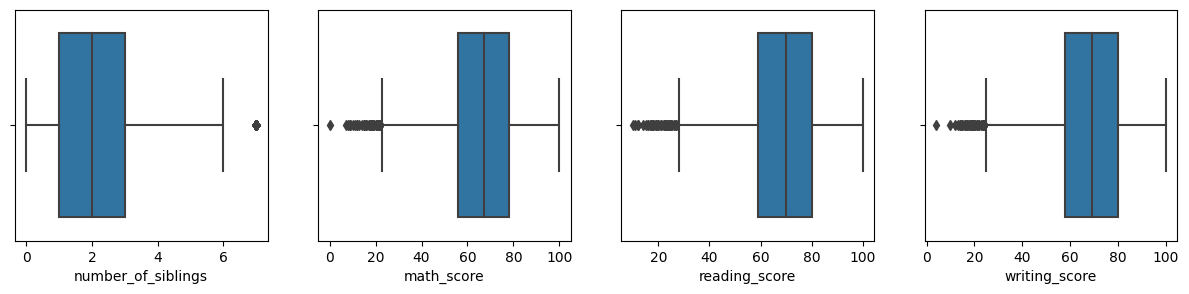

In [52]:
## Create a boxplot to check outliers

fig, ax = plt.subplots(1,4,figsize=(15,3))
sns.boxplot(x=exam_scores['number_of_siblings'], ax=ax[0])
sns.boxplot(x=exam_scores['math_score'], ax=ax[1])
sns.boxplot(x=exam_scores['reading_score'], ax=ax[2])
sns.boxplot(x=exam_scores['writing_score'], ax=ax[3])

plt.show()

The boxplots above confirm the presence of outliers in the dataset.

### **Relationship between Variables**

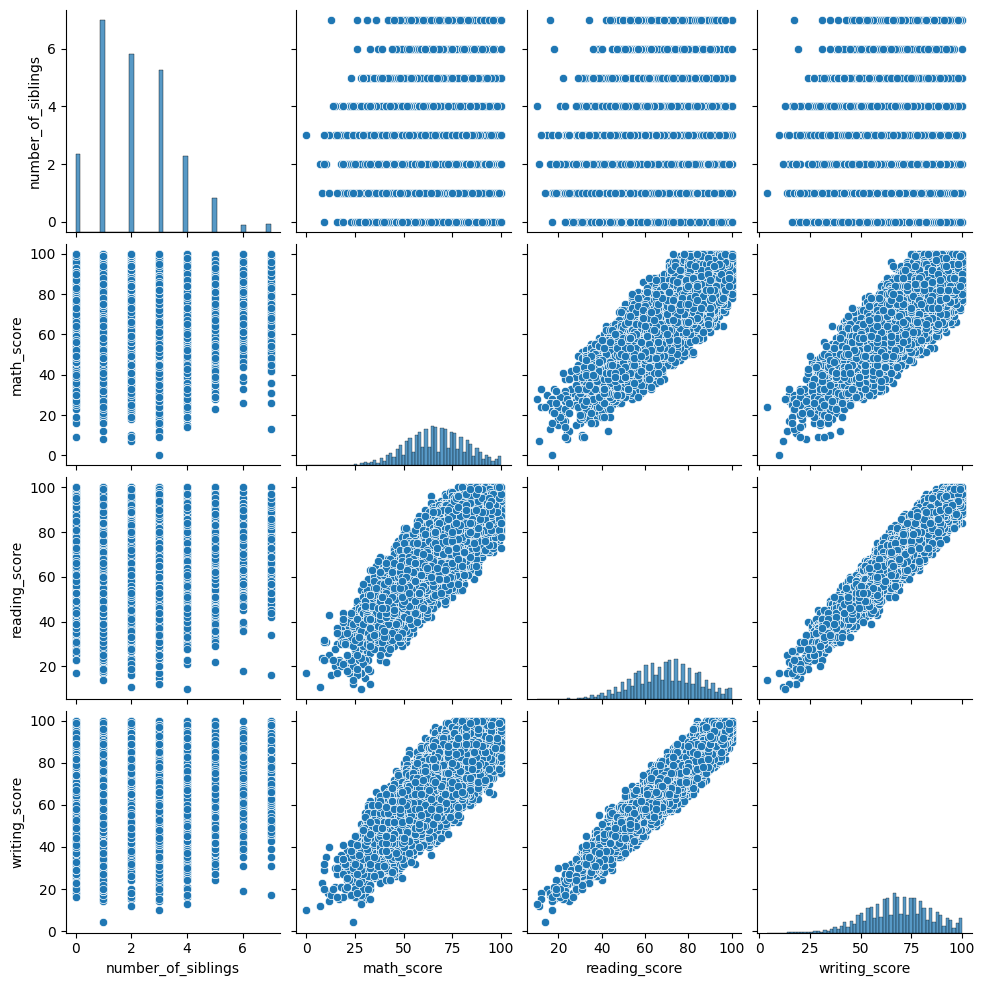

In [54]:
## Create pairwise scatterplots from the dataset

sns.pairplot(data=exam_scores)

plt.show()

Based from the scatterplots above, students with 6 or more siblings scored a bit higher from other students. The relationship between 'reading_score', 'writing_score', and 'math_score' produced a clustered scatterplot, with the relationship 'reading_score' and 'writing_score' being more clustered, which indicates a strong relationship between these variables.

#### **Relationship between social variables - gender, ethnic_group, parents_education, and parent_marital_status between exam scores**

Next, we will check if social variables, such as `gender`, `ethnic_group`, `parents_education`, and `parent_marital_status` affect the exam scores of the students.

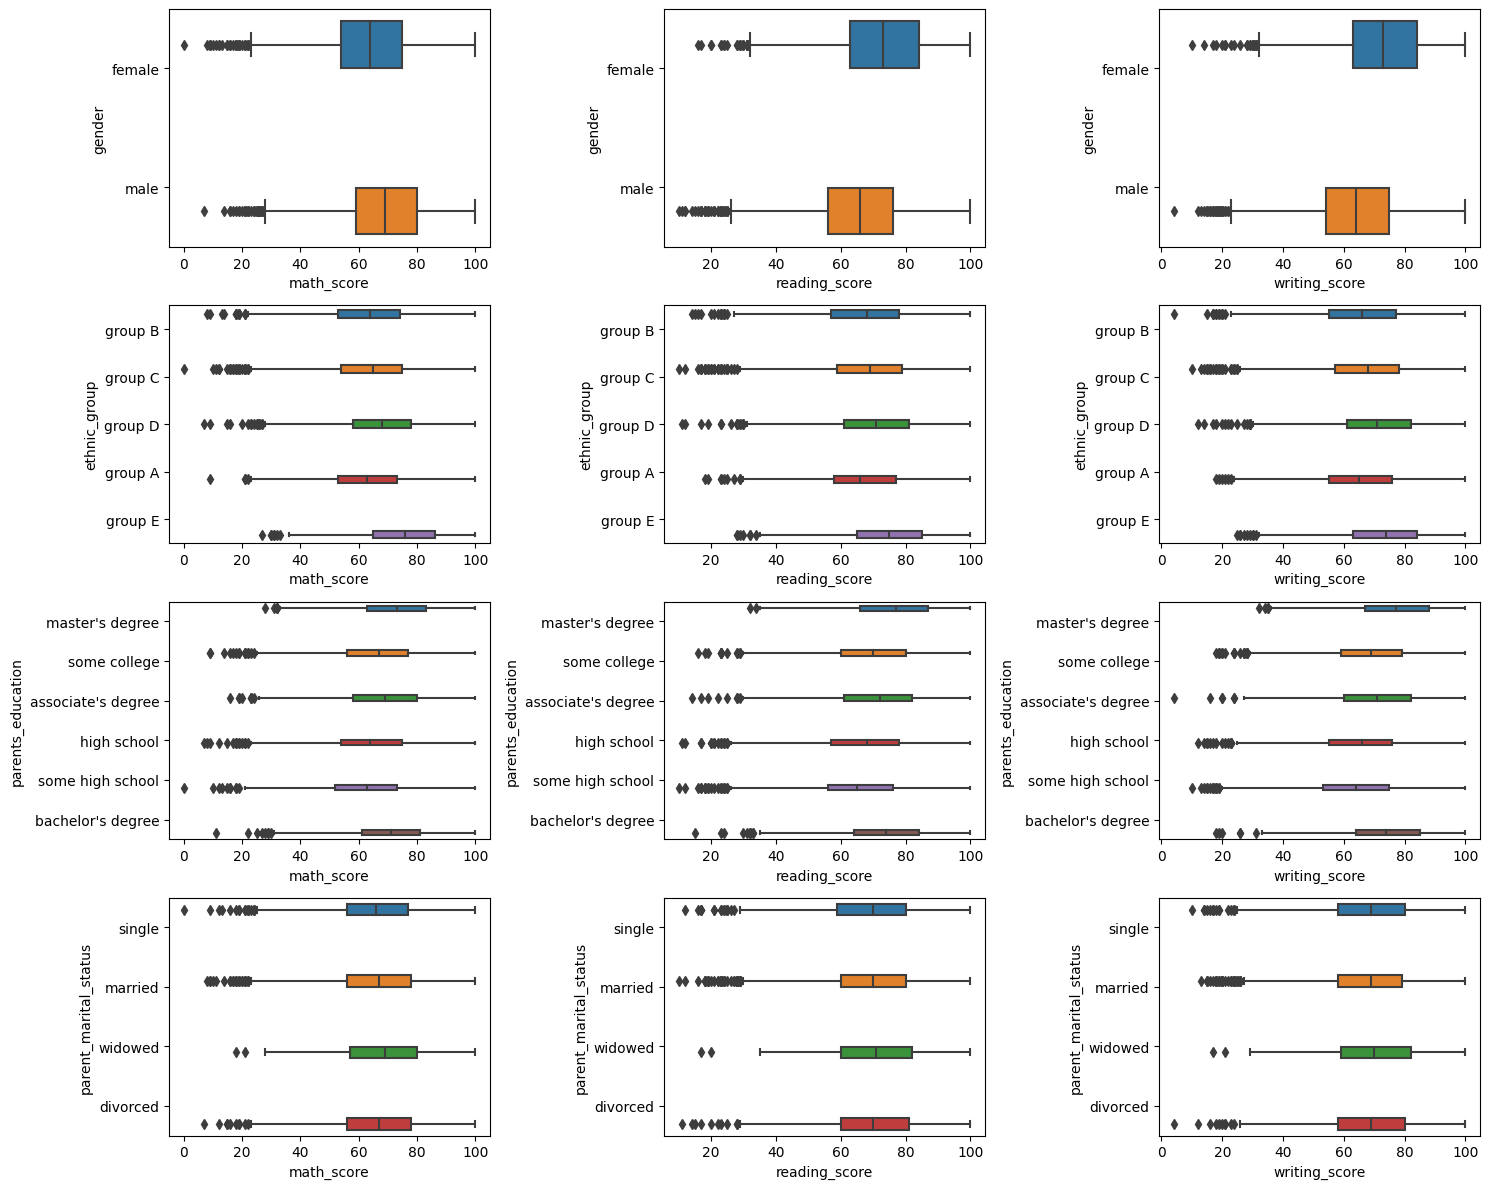

In [98]:
## Plot the relationship between variables

cat_social_columns = ['gender','ethnic_group','parents_education','parent_marital_status']
scores = ['math_score','reading_score','writing_score']

fig, axes = plt.subplots(len(cat_social_columns), len(scores), figsize=(15,12))

for i, soc_col in enumerate(cat_social_columns):
    for j, scr in enumerate(scores):
        ax = axes[i,j]
        sns.boxplot(data=exam_scores, x=scr, y=soc_col, hue=soc_col, ax=ax)
        ax.legend([],[], frameon=False)
        
plt.tight_layout()
plt.show()

**Relationship between 'gender' and exam scores**
    
- Male students scored a bit higher in Math compared to female students.
- Female students scored a bit higher in Reading and Writing compared to male students.

**Relationship between 'ethnic_group' and exam scores**

- Ethnic group E scored higher on all subjects compared to other ethnic groups.
- The hierarchy of scores for the different ethnic groups is the same for the three exam types.

**Relationship between 'parents_education' and exam scores**

- Students with parents who finished Master's Degree and Bachelor's Degree scored higher in all exams.
- The hierarchy of scores for the different variables is the same for the three exam types.

**Relationship between 'parents_marital_status' and exam scores**

- There are very insignificant difference in the exam scores given the variables from the 'parent_marital_status' column, except for a few outliers.